In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
image = cv2.imread('db.jpg')

In [3]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image)
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()

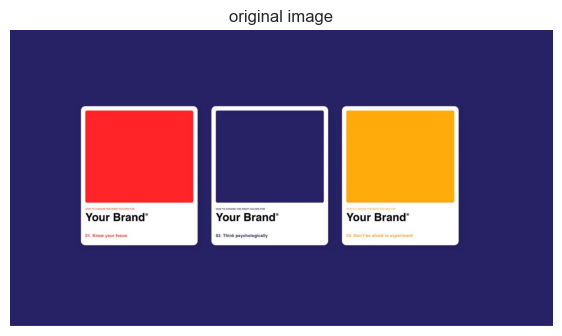

In [4]:
draw_picture(image, 'original image')

In [5]:
resized_image = cv2.resize(image, (256, 124))

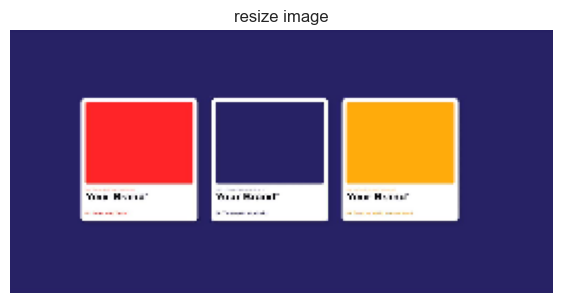

In [6]:
draw_picture(resized_image, 'resize image') # чтобы быстрее вычислялось

In [7]:
original_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

## KMeans

**Описание:** K-средних - это один из наиболее популярных и простых методов кластеризации. Он разделяет набор данных на K кластеров, где K - это заранее заданное число кластеров. Алгоритм стремится минимизировать среднее квадратичное расстояние между точками внутри одного кластера и центром этого кластера.

**Преимущества:** Прост в понимании и реализации, хорошо работает на сбалансированных и компактных кластерах.

**Недостатки:** Не всегда хорошо справляется с кластерами несферической формы, требует заранее заданного числа кластеров (K), чувствителен к начальным условиям.


In [8]:
K_values = [2, 5, 10, 20]
ssim_values_kmeans = []
clustered_images = []

In [9]:
global clustered_image, similarity

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(resized_image.reshape(-1, 3))
    clustered_image = kmeans.cluster_centers_[kmeans.labels_].reshape(resized_image.shape).astype('uint8')

    clustered_image_gray = cv2.cvtColor(clustered_image, cv2.COLOR_BGR2GRAY)

    similarity = ssim(original_image, clustered_image_gray)
    ssim_values_kmeans.append(similarity)

    clustered_images.append(clustered_image_gray)

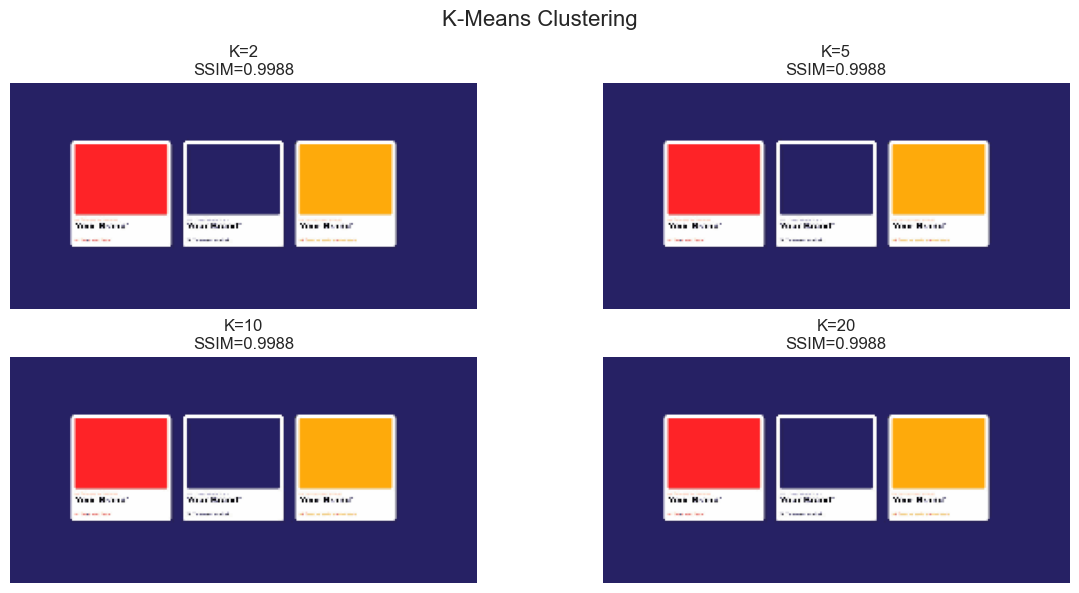

In [10]:
num_rows = 2
num_cols = len(K_values) // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, k in enumerate(K_values):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(cv2.cvtColor(clustered_image, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f'K={k}\nSSIM={similarity:.4f}')
    axes[row, col].axis('off')

plt.suptitle('K-Means Clustering', size=16)
plt.tight_layout()
plt.show()

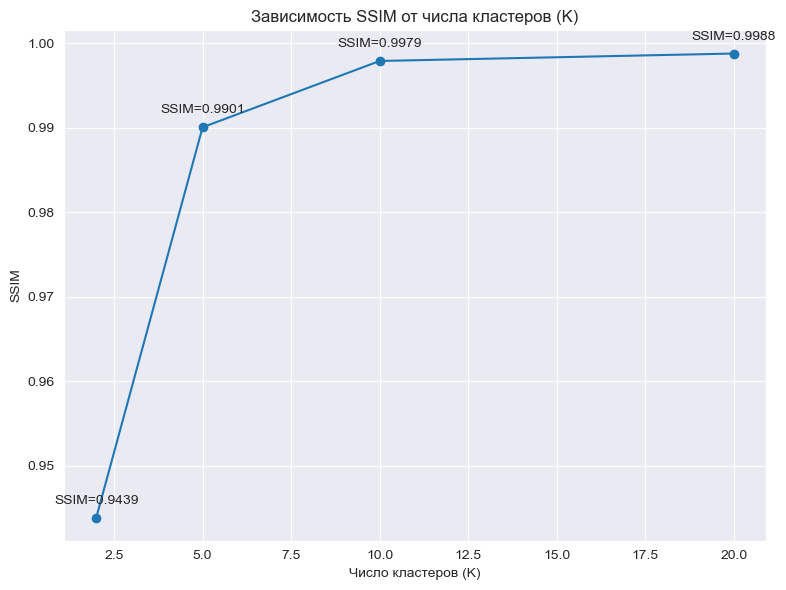

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(K_values, ssim_values_kmeans, marker='o', linestyle='-')
plt.title('Зависимость SSIM от числа кластеров (K)')
plt.xlabel('Число кластеров (K)')
plt.ylabel('SSIM')
plt.grid(True)


for i, txt in enumerate(ssim_values_kmeans):
    plt.annotate(f'SSIM={txt:.4f}', (K_values[i], ssim_values_kmeans[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

## DBSCAN

**Описание:** DBSCAN - это метод кластеризации, основанный на плотности данных. Он может обнаруживать кластеры произвольной формы, и он не требует заранее заданного числа кластеров. DBSCAN определяет кластер как набор точек, где каждая точка имеет минимальное количество соседей внутри некоторого радиуса.

**Преимущества:** Автоматическое обнаружение числа кластеров, способен работать с кластерами разной формы и плотности, может обрабатывать выбросы (шум).

**Недостатки:** Чувствителен к параметрам (радиус и минимальное количество соседей), менее эффективен на данных с различной плотностью.


In [12]:
from sklearn.cluster import DBSCAN

eps_values = [0.5, 3, 7]
min_samples_values = [3, 5, 7]
ssim_values_db = []

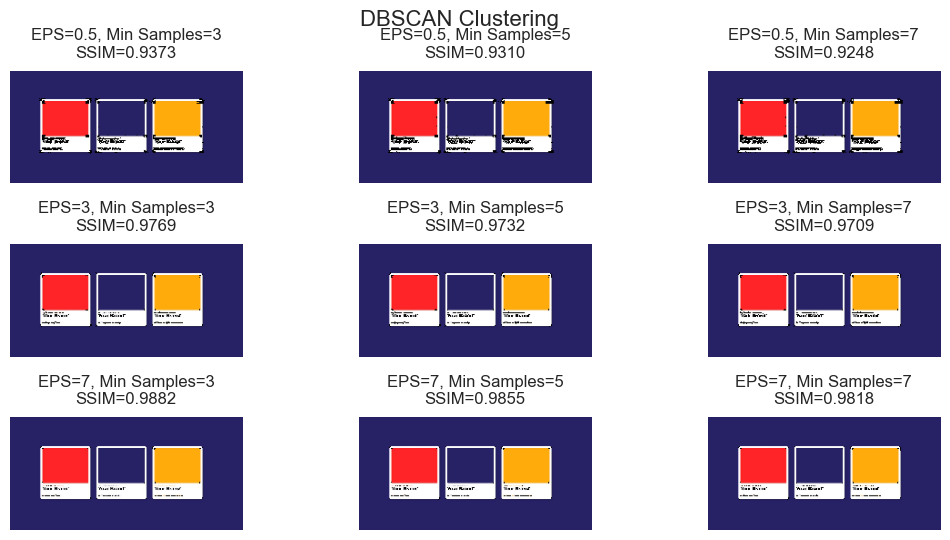

In [13]:
num_rows = len(eps_values)
num_cols = len(min_samples_values)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(resized_image.reshape(-1, 3))
        labels = dbscan.labels_

        noise_mask = (labels == -1).reshape(resized_image.shape[0], resized_image.shape[1]) 

        clustered_image = resized_image.copy()
        clustered_image[noise_mask] = [0, 0, 0]

        clustered_image_gray = cv2.cvtColor(clustered_image, cv2.COLOR_BGR2GRAY)

        similarity = ssim(original_image, clustered_image_gray)
        ssim_values_db.append(similarity)

        axes[i, j].imshow(cv2.cvtColor(clustered_image, cv2.COLOR_BGR2RGB))

        axes[i, j].set_title(f'EPS={eps}, Min Samples={min_samples}\nSSIM={similarity:.4f}', pad=10)
        axes[i, j].axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle('DBSCAN Clustering', size=16)
plt.show()

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        similarity = ssim_values_db[i * len(min_samples_values) + j]
        # print(f'EPS={eps}, Min Samples={min_samples}, SSIM={similarity:.4f}')

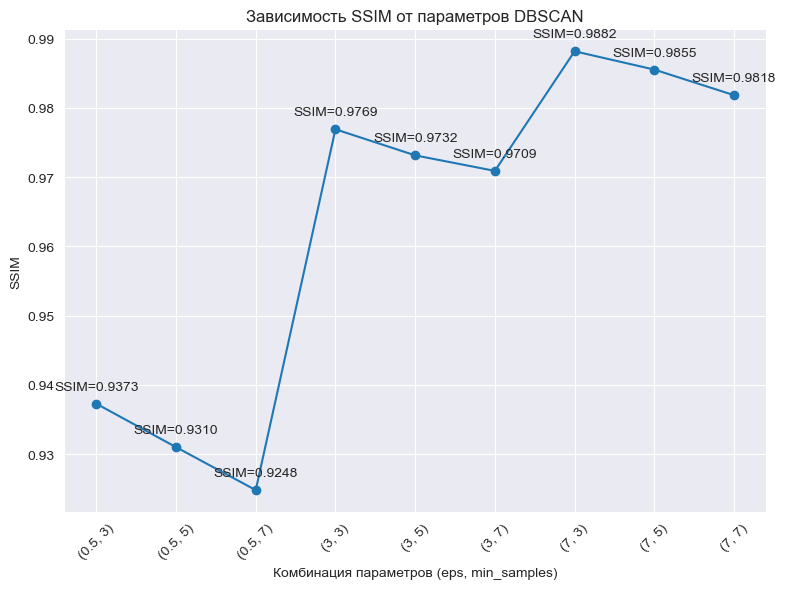

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(ssim_values_db, marker='o', linestyle='-')
plt.title('Зависимость SSIM от параметров DBSCAN')
plt.xlabel('Комбинация параметров (eps, min_samples)')
plt.ylabel('SSIM')
plt.xticks(range(len(ssim_values_db)), [f'({eps}, {min_samples})' for eps in eps_values for min_samples in min_samples_values], rotation=45)
plt.grid(True)

for i, txt in enumerate(ssim_values_db):
    plt.annotate(f'SSIM={txt:.4f}', (i, ssim_values_db[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

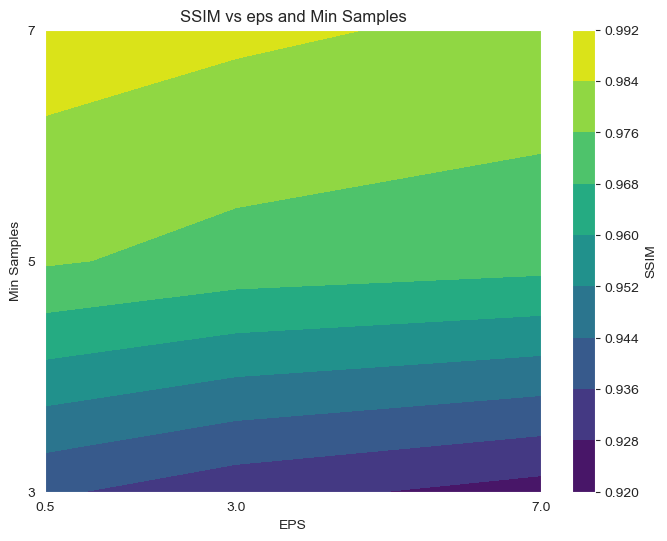

In [15]:
eps_grid, min_samples_grid = np.meshgrid(eps_values, min_samples_values)

ssim_grid = np.array(ssim_values_db).reshape(3, 3)

# контурный график для визуализации зависимости SSIM от eps и min_samples
plt.figure(figsize=(8, 6))
contour = plt.contourf(eps_grid, min_samples_grid, ssim_grid, cmap='viridis')
plt.colorbar(contour, label='SSIM')

plt.title('SSIM vs eps and Min Samples')
plt.xlabel('EPS')
plt.ylabel('Min Samples')
plt.xticks(eps_values)
plt.yticks(min_samples_values)
plt.grid(True)
plt.show()

## AgglomerativeClustering

**Описание:** Этот метод является иерархической кластеризацией, где каждая точка начинает как отдельный кластер, а затем постепенно объединяется с ближайшими кластерами до достижения заданного числа кластеров. Это создает дерево кластеров, называемое дендрограммой.

**Преимущества:** Позволяет исследовать иерархию кластеров, не требует заранее заданного числа кластеров, способен обрабатывать данные разной формы.

**Недостатки:** Может быть вычислительно дорогостоящим на больших наборах данных, не всегда хорошо справляется с кластерами несферической формы.

In [16]:
from sklearn.cluster import AgglomerativeClustering

K_values = [2, 5, 10, 20]
ssim_values_agg = []

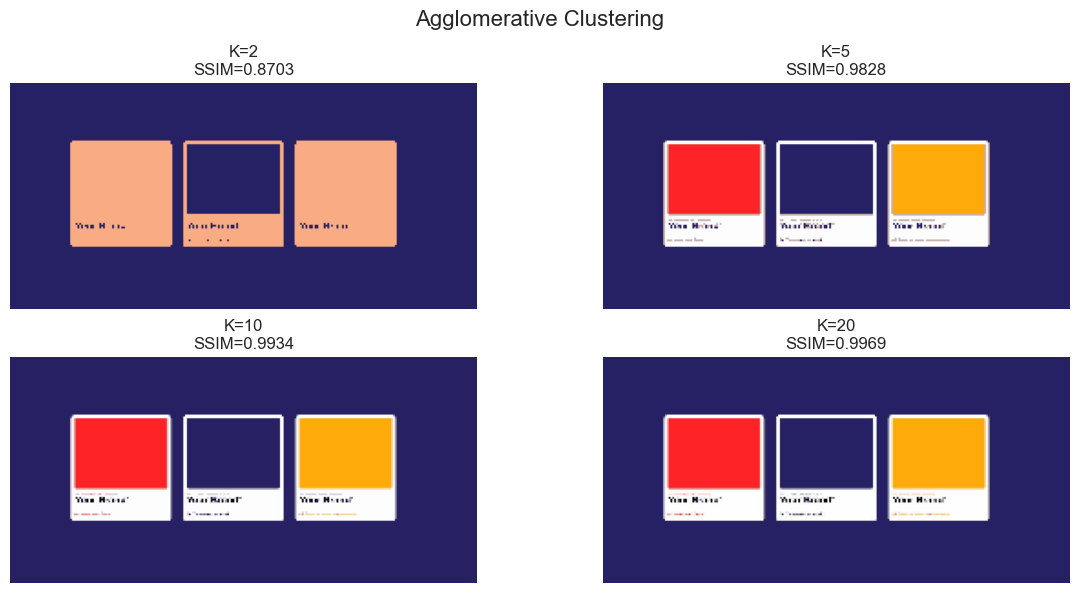

In [17]:
num_rows = 2
num_cols = len(K_values) // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

for i, K in enumerate(K_values):
    model = AgglomerativeClustering(n_clusters=K)
    pixels = resized_image.reshape(-1, 3)
    labels = model.fit_predict(pixels)

    segmented_image = np.zeros_like(pixels)
    for label in range(K):
        segmented_image[labels == label] = np.mean(pixels[labels == label], axis=0)

    segmented_image = segmented_image.reshape(resized_image.shape).astype(np.uint8)

    similarity = ssim(resized_image, segmented_image, multichannel=True)
    ssim_values_agg.append(similarity)

    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(f'K={K}\nSSIM={similarity:.4f}')
    axes[row, col].axis('off')

plt.suptitle('Agglomerative Clustering', size=16)
plt.tight_layout()
plt.show()

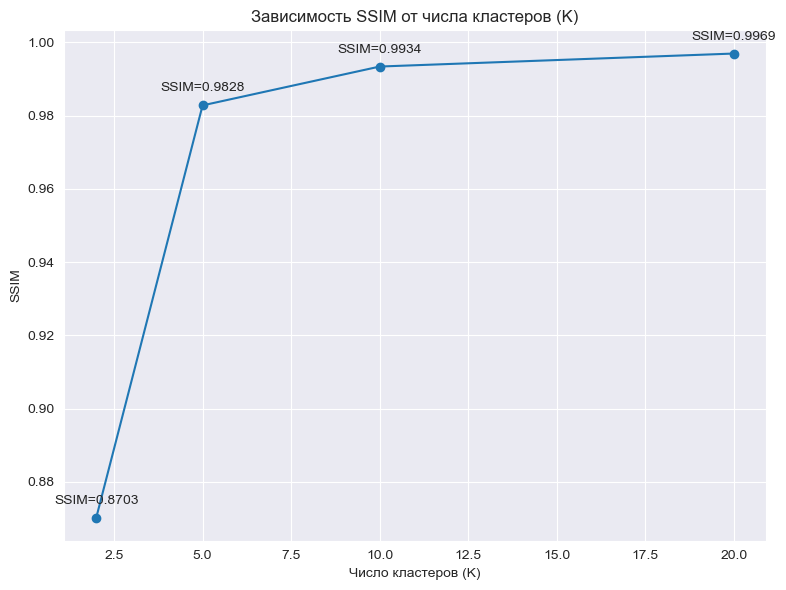

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(K_values, ssim_values_agg, marker='o', linestyle='-')
plt.title('Зависимость SSIM от числа кластеров (K)')
plt.xlabel('Число кластеров (K)')
plt.ylabel('SSIM')
plt.grid(True)

for i, txt in enumerate(ssim_values_agg):
    plt.annotate(f'SSIM={txt:.4f}', (K_values[i], ssim_values_agg[i]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.tight_layout()
plt.show()

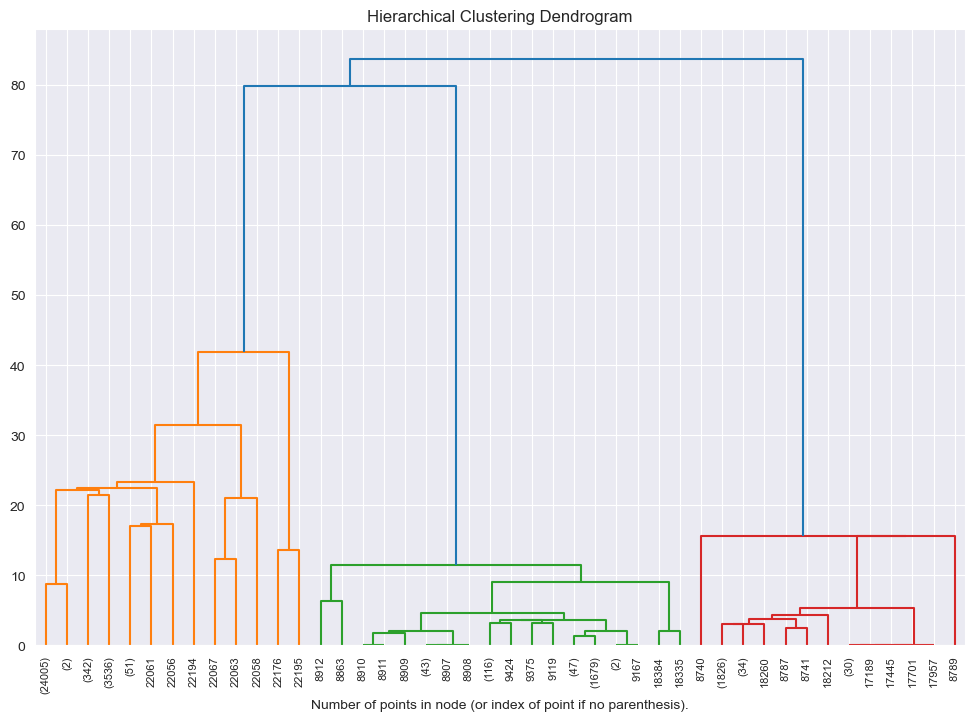

In [19]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

# Преобразовать изображение в одномерный массив
image_data = resized_image.reshape(-1, 3)

# Создать модель AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

# Провести кластеризацию
model = model.fit(image_data)

# Построить дендрограмму
plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [21]:
data = {
    f'KMeans': ssim_values_kmeans,
    'DBSCAN (eps=0.5; min_samples=3, 5, 7)': ssim_values_db[0:3] + ['ничего нет'],
    'DBSCAN (eps=3; min_samples=3, 5, 7)': ssim_values_db[3:6] + ['ничего нет'],
    'DBSCAN (eps=7; min_samples=3, 5, 7)': ssim_values_db[6:9]+ ['ничего нет'],
    'AgglomerativeClustering': ssim_values_agg,
}

df = pd.DataFrame(data, index=[2, 5, 10, 20])
df

,KMeans,"DBSCAN (eps=0.5; min_samples=3, 5, 7)","DBSCAN (eps=3; min_samples=3, 5, 7)","DBSCAN (eps=7; min_samples=3, 5, 7)",AgglomerativeClustering
2,0.943864,0.93728,0.976922,0.988193,0.870276
5,0.990050,0.931004,0.973155,0.985547,0.982776
10,0.997899,0.924796,0.970912,0.981848,0.993380
20,0.998779,ничего нет,ничего нет,ничего нет,0.996930


Вывод: слишком долгое обучение. Приходится сжимать изображение, что очень грустно.   
Метод KMeans мне понравился больше всего. Понятный, достаточно быстрый, относительно время/качество выигрывает для меня. Общие черты изображений распознает (не всегда так будет, но на протестированных мною данных все было отлично).   
Метод DBSCAN мне не понравился. Постоянно какие-то ошибки, нужно как-то подобрать правильно параметры, учесть выбросы, все это долго обрабатывается, потому что параметров много (если делать перебор). Метод далгий и дает не самые высокие показатели (хотя очень даже неплохие)
Метод AgglomerativeClustering показал лучшие результаты ssim. Но он исполняется дольше всего. Однако из-за того, что подбирать надо только один параметр, вычисления происходят все равно быстрее, чем для DBSCAN в данной задаче. Данный алгоритм показывает хорошую точность кластеризации. Если это важно и не так нужна скорость, то выбираем его. 